<a href="https://colab.research.google.com/github/hamednasr/deep-learning/blob/main/my_code_sine_extrapolate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

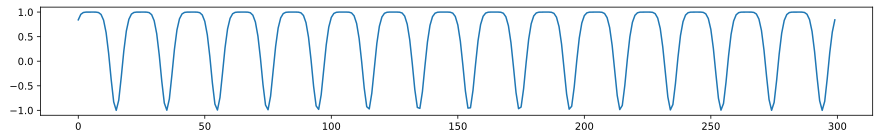

In [57]:
N = 300
t = np.linspace(0 , 30*np.pi, num = N)

data = np.sin(t + np.cos(t))

plt.figure(figsize=(15,2))
# plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data)
# plt.xlim([-1,N+1])
plt.show()

In [58]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x):
    
    # run through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden

In [59]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  5 # breadth of model (number of units in hidden layers)
num_layers =  2 # depth of model (number of "stacks" of hidden layers)
seqlength  =  50 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet(input_size,num_hidden,num_layers)

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([50, 1, 1])
torch.Size([50, 1, 1])
torch.Size([2, 1, 5])


In [60]:
# test the model with some data
data = torch.FloatTensor(data)
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

tensor(1.0609, grad_fn=<MseLossBackward0>)

In [61]:
# number of training epochs
numepochs = 70

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.Adam(net.parameters(),lr=.0001)


# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []

  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())


  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)

  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 70/70

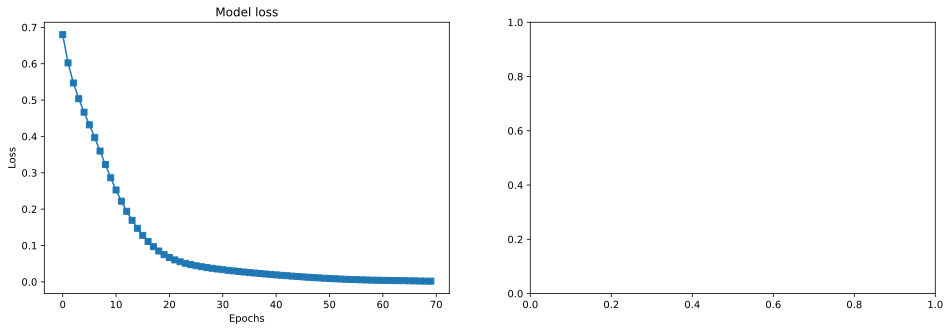

In [62]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')


plt.show()

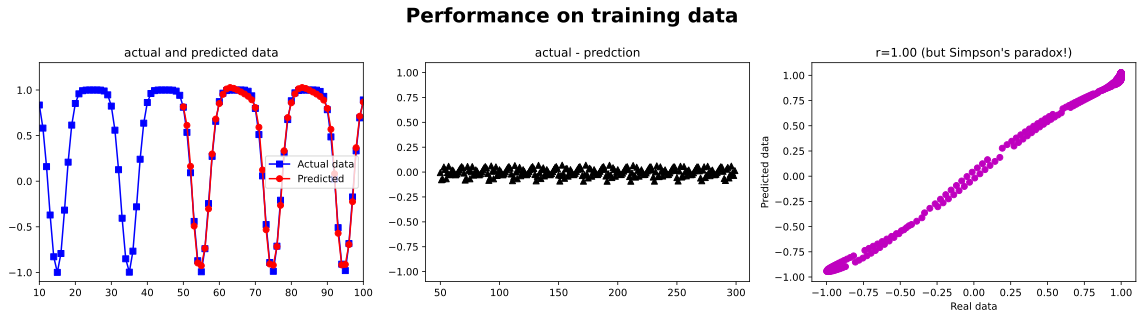

In [64]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  # h[timei+seqlength,:] = hh.detach()


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_xlim([10,100])
ax[0].set_ylim([-1.1,1.3])
ax[0].set_title('actual and predicted data')
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('actual - predction')


ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

## test on new data

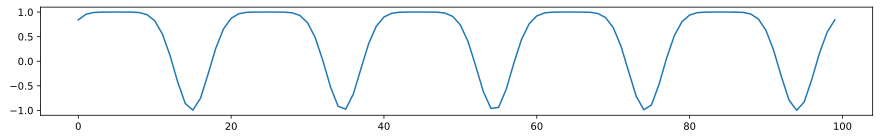

In [68]:
N = 100
t = np.linspace(0 , 10*np.pi, num = N)

data = np.sin(t + np.cos(t))

plt.figure(figsize=(15,2))
# plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data)
# plt.xlim([-1,N+1])
plt.show()

In [69]:
data = torch.FloatTensor(data)

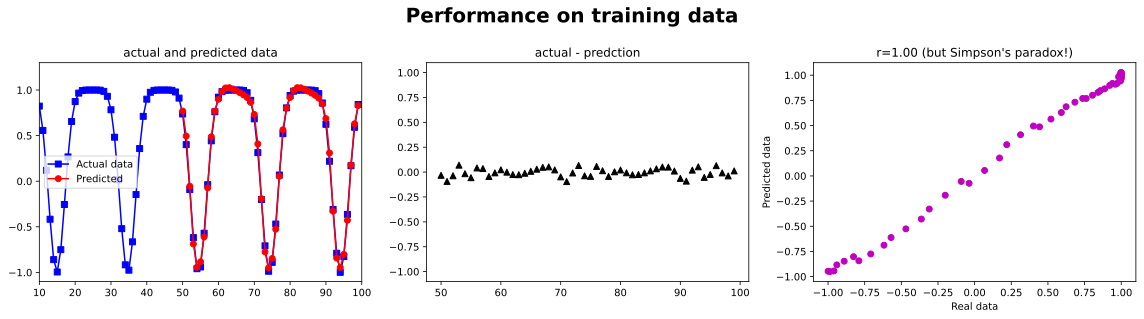

In [70]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  # h[timei+seqlength,:] = hh.detach()
# 

## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_xlim([10,100])
ax[0].set_ylim([-1.1,1.3])
ax[0].set_title('actual and predicted data')
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('actual - predction')


ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

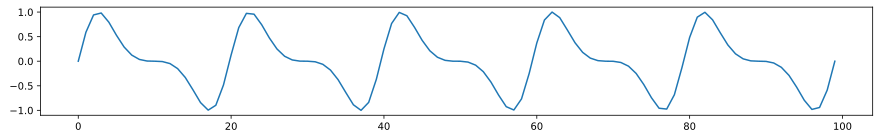

In [71]:
N = 100
t = np.linspace(0 , 10*np.pi, num = N)

data = np.sin(t + np.sin(t))

plt.figure(figsize=(15,2))
# plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data)
# plt.xlim([-1,N+1])
plt.show()

In [72]:
data = torch.FloatTensor(data)

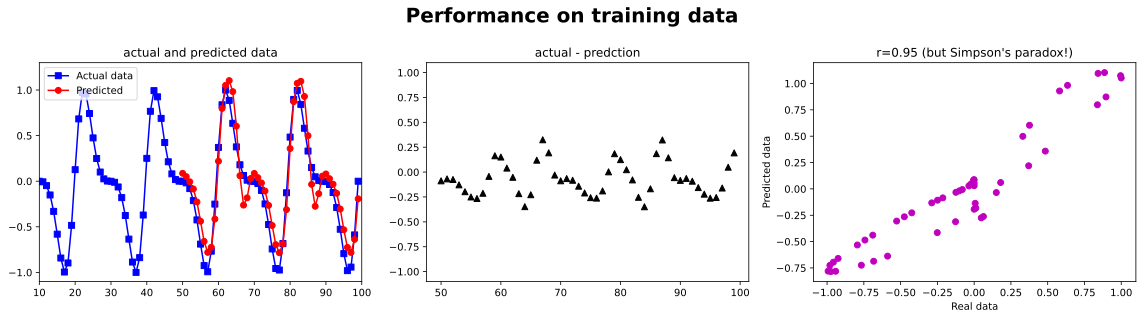

In [73]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  # h[timei+seqlength,:] = hh.detach()


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_xlim([10,100])
ax[0].set_ylim([-1.1,1.3])
ax[0].set_title('actual and predicted data')
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('actual - predction')


ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

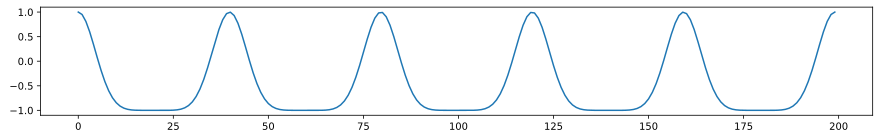

In [74]:
N = 200
t = np.linspace(0 , 10*np.pi, num = N)

data = np.cos(t + np.sin(t))

plt.figure(figsize=(15,2))
# plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data)
# plt.xlim([-1,N+1])
plt.show()

In [75]:
data = torch.FloatTensor(data)

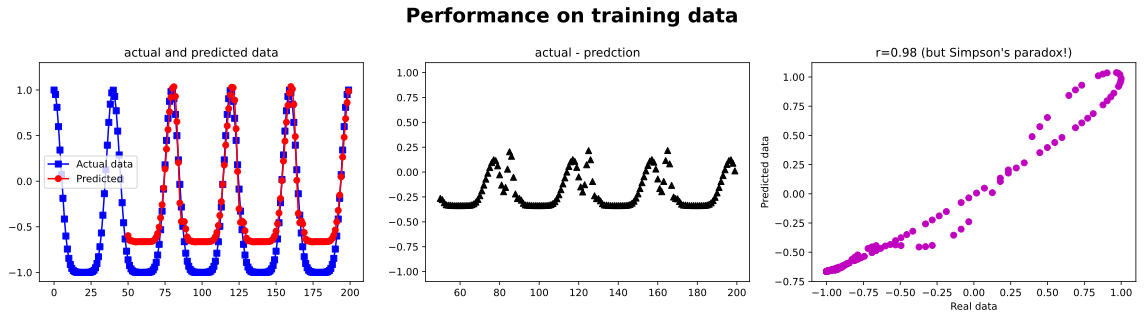

In [76]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  # h[timei+seqlength,:] = hh.detach()


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
# ax[0].set_xlim([10,100])
ax[0].set_ylim([-1.1,1.3])
ax[0].set_title('actual and predicted data')
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('actual - predction')


ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()